# ORF recognition by CNN

Use variable number of bases between START and STOP. Thus, ncRNA will have its STOP out-of-frame or too close to the START, and pcRNA will have its STOP in-frame and far from the START.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-17 16:35:37 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=36            # how long is each sequence
CDS_LEN=18            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=300  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
import random
def partition_random_sequences(goal_per_class):
    pc_seqs=[]
    nc_seqs=[]
    oc = ORF_counter()
    trials = 0
    pc_cnt = 0
    nc_cnt = 0
    bases=['A','C','G','T']
    while pc_cnt<goal_per_class or nc_cnt<goal_per_class:
        trials += 1        
        between_bases = random.randint(0,RNA_LEN-6) 
        utr5_bases = (RNA_LEN - (between_bases + 6)) // 2
        utr3_bases = RNA_LEN - (utr5_bases + (between_bases+6))
        one_seq  = "".join(random.choices(bases,k=utr5_bases)) 
        one_seq += 'ATG'    
        one_seq += "".join(random.choices(bases,k=between_bases)) 
        random_stop = random.choice(['TAA','TAG','TGA']) # random frame
        one_seq += random_stop
        one_seq += "".join(random.choices(bases,k=utr3_bases))  
        if len(one_seq) != RNA_LEN:
            print("WRONG LENGTH:",len(one_seq),utr5_bases,between_bases,utr3_bases)
        oc.set_sequence(one_seq)
        cds_len = oc.get_max_cds_len() + 3
        if cds_len >= CDS_LEN and pc_cnt<goal_per_class:
            pc_cnt += 1
            pc_seqs.append(one_seq)
        elif cds_len < CDS_LEN and nc_cnt<goal_per_class:
            nc_cnt += 1
            nc_seqs.append(one_seq)
    print ("It took %d trials to reach %d per class."%(trials,goal_per_class))
    return pc_seqs,nc_seqs
pc_all,nc_all=partition_random_sequences(10)  # just testing
pc_all,nc_all=partition_random_sequences(PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 20 trials to reach 10 per class.
It took 92275 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 36.0
Average ORF length: 19.901272727272726
NC seqs
Average RNA length: 36.0
Average ORF length: 1.987818181818182


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (36, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4624      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)           

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/300
1334/1334 [==============================] - 18s 4ms/step - loss: 0.6609 - accuracy: 0.5968 - val_loss: 0.5667 - val_accuracy: 0.7046
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5608 - accuracy: 0.7120 - val_loss: 0.5168 - val_accuracy: 0.7436
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5215 - accuracy: 0.7332 - val_loss: 0.4743 - val_accuracy: 0.7659
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/300
1334/1334 [==============================] - 5s 3ms/step - loss: 0.4918 - accuracy: 0.7504 - val_loss: 0.4582 - val_accuracy: 0.7782
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4744 - accuracy: 0.7609 - val_loss: 0.4338 - val_accuracy: 0.7888
INFO:tensorflow:Assets wri

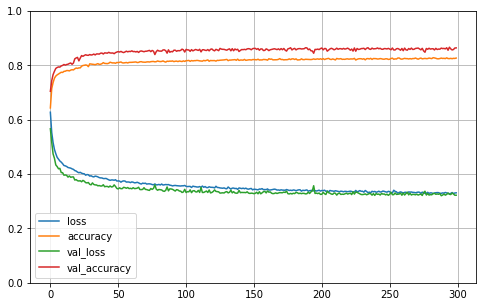

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/300
1334/1334 [==============================] - 6s 4ms/step - loss: 0.6619 - accuracy: 0.5924 - val_loss: 0.5555 - val_accuracy: 0.7164
Epoch 2/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5563 - accuracy: 0.7111 - val_loss: 0.4976 - val_accuracy: 0.7553
Epoch 3/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5081 - accuracy: 0.7419 - val_loss: 0.4652 - val_accuracy: 0.7802
Epoch 4/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4875 - accuracy: 0.7580 - val_loss: 0.4429 - val_accuracy: 0.7921
Epoch 5/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4750 - accuracy: 0.7674 - val_loss: 0.4344 - val_accuracy: 0.7996
Epoch 6/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4633 - accuracy: 0.7712 - val_loss: 0.4243 - val_accuracy: 0.8018
Epoch 7/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4495 - accu

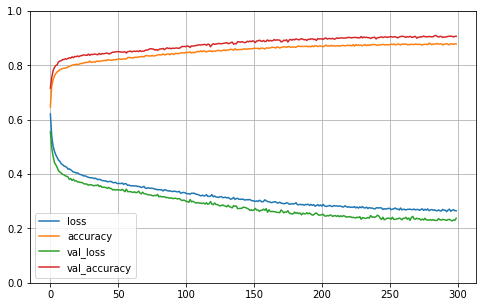

MODEL
make_DNN
input shape: (36, 4)
FIT
Epoch 1/300
1334/1334 [==============================] - 6s 4ms/step - loss: 0.6628 - accuracy: 0.6005 - val_loss: 0.5600 - val_accuracy: 0.7076
Epoch 2/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5541 - accuracy: 0.7112 - val_loss: 0.5074 - val_accuracy: 0.7517
Epoch 3/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.5114 - accuracy: 0.7458 - val_loss: 0.4754 - val_accuracy: 0.7804
Epoch 4/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4813 - accuracy: 0.7659 - val_loss: 0.4537 - val_accuracy: 0.7911
Epoch 5/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4672 - accuracy: 0.7745 - val_loss: 0.4391 - val_accuracy: 0.7989
Epoch 6/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4566 - accuracy: 0.7769 - val_loss: 0.4252 - val_accuracy: 0.8076
Epoch 7/300
1334/1334 [==============================] - 5s 4ms/step - loss: 0.4494 - accu

In [ ]:
do_cross_validation(X,y)

In [ ]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [ ]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))